# Regression Model Test

## Imports

In [5]:
import tensorflow as tf
from tensorflow import keras
from loadData import createDataset, createDataframe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
model_path = '../../log/saved_models/mtm_classification_cascade_noAgeGroup/'
test_dir = '../../data/m3/test'
batch_size = 32
image_height = 160
image_width = 160

use_age_groups = False
num_age_classes = 8 if use_age_groups else 122
age_classes_dict = {
    0 : "0-13",
    1 : "14-19",
    2 : "20-29",
    3 : "30-39",
    4 : "40-49",
    5 : "50-59",
    6 : "60+",
    7 : "-"
}

## Load the model

In [7]:
loaded_model = keras.models.load_model(model_path)

## Evaluating the test data

In [8]:
x, y_face, y_mask, y_age = createDataset(test_dir, (image_height, image_width), for_regression=False)

results = loaded_model.evaluate(
    x, 
    {
        'face_output' : y_face,
        'mask_output' : y_mask,
        'age_output' : y_age
})

print(f'Loss: {results[0]}; Accuracy: {results[1]}')

14/14 [==============================] - 11s 682ms/step - loss: 1.3205 - face_output_loss: 2.0847 - mask_output_loss: 0.0393 - age_output_loss: 1.8774 - face_output_binary_accuracy: 0.9932 - mask_output_binary_accuracy: 0.9932 - age_output_categorical_accuracy: 0.5360
Loss: 1.3204718828201294; Accuracy: 2.0846781730651855


In [9]:
def get_img_predictions(img_path):
    # Loading and preprocessing the image
    img = tf.keras.utils.load_img(
        img_path, target_size=(image_height, image_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

    # Let the model make a prediction for the image
    preds = loaded_model.predict(img_array_batch)

    # Getting face, mask and age prediction
    face_pred = round(preds[0][0][0], 4)
    mask_pred = round(preds[1][0][0], 4)
    age_pred = np.argmax(preds[2][0])

    age_output_indexes = np.array([i for i in range(0, num_age_classes)])
    avg_age_pred = int(np.sum(preds[2][0] * age_output_indexes))

    return img, face_pred, mask_pred, age_pred, avg_age_pred

In [10]:
df = createDataframe(test_dir, for_regression=True)

#print(df)

df_length = len (df.index)

df_test = pd.DataFrame()
empty_arr = [None] * df_length
df_test['face_pred'], df_test['mask_pred'], df_test['age_pred'], df_test['avg_age_pred'] = empty_arr, empty_arr, empty_arr, empty_arr
df_test['face_diff'], df_test['mask_diff'], df_test['age_diff'], df_test['total_diff'] = empty_arr, empty_arr, empty_arr, empty_arr

c = 0

for img_path in df['image']:
    img, face_pred, mask_pred, age_pred, avg_age_pred = get_img_predictions(img_path)
    
    df_test['face_pred'][c] = face_pred
    df_test['mask_pred'][c] = mask_pred
    df_test['age_pred'][c] = age_pred
    df_test['avg_age_pred'][c] = avg_age_pred

    df_test['face_diff'][c] = round(abs(df['face'][c] - face_pred), 4)
    df_test['mask_diff'][c] = round(abs(df['mask'][c] - mask_pred), 4)
    df_test['age_diff'][c] = round(abs(df['age'][c] - age_pred) / 120, 4)

    df_test['total_diff'][c] = round((df_test['face_diff'][c] + df_test['mask_diff'][c] + df_test['age_diff'][c]) / 3, 4)

    c+=1

df_combined = df.join(df_test)
df_combined.to_csv(f'{model_path}eval_results.csv')

print(df_combined)

1/1 [==============================] - 0s 64ms/step
                                              image  face  mask  age  \
0    ../../data/m3/test\face\mask\1_1_18_901540.jpg     1     1   18   
1    ../../data/m3/test\face\mask\1_1_18_903787.jpg     1     1   18   
2    ../../data/m3/test\face\mask\1_1_19_901522.jpg     1     1   19   
3    ../../data/m3/test\face\mask\1_1_19_902187.jpg     1     1   19   
4    ../../data/m3/test\face\mask\1_1_19_902189.jpg     1     1   19   
..                                              ...   ...   ...  ...   
439     ../../data/m3/test\noFace\0_0_-1_300197.jpg     0     0  121   
440     ../../data/m3/test\noFace\0_0_-1_300198.jpg     0     0  121   
441     ../../data/m3/test\noFace\0_0_-1_300199.jpg     0     0  121   
442     ../../data/m3/test\noFace\0_0_-1_300200.jpg     0     0  121   
443     ../../data/m3/test\noFace\0_0_-1_300201.jpg     0     0  121   

    face_pred mask_pred age_pred avg_age_pred face_diff mask_diff age_diff  \
0    

## Predict new images

1/1 [==============================] - 0s 60ms/step


Text(0.5, 1.0, 'Face: 100.00% | Mask: 0.14% | Age: 101 (Actual: 26)')

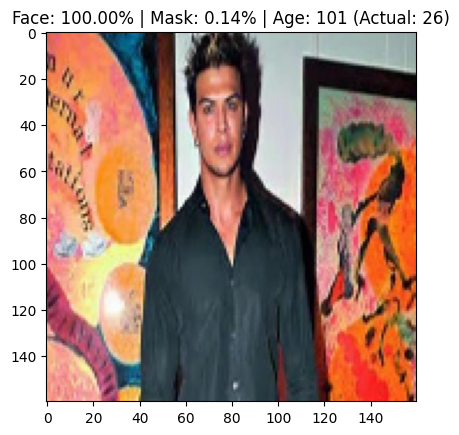

In [24]:
# Getting the image path for image to predict
img_path = '../../data/m3/extra/1_0_26_706657.jpg'
img_path_split = img_path.split('/')
img_name = img_path_split[len(img_path_split)-1]
img_name_split = img_name.split('_')

# Getting the actual age from the file name
if(len(img_name_split) > 2 and str.isnumeric(img_name_split[2])):
    age_actual = img_name_split[2]
else:
    age_actual = '?'

img, face_pred, mask_pred, age_pred, avg_age_pred = get_img_predictions(img_path)

if use_age_groups:
    age_pred = age_classes_dict[age_pred]
else:
    age_pred = str(avg_age_pred)
    if age_pred == "121": age_pred = "-"

# Showing the image with the corresponding predictions
ax = plt.subplot(1, 1, 1)
plt.imshow(img)
plt.title("Face: {:.2f}% | Mask: {:.2f}% | Age: {} (Actual: {})".format(face_pred * 100, mask_pred * 100, age_pred, age_actual))